# Heuristics for finding clusters

In [1]:
from functools import total_ordering
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import warnings

class Vertex:
    """ 
    Class representing a vertex in a graph.
    
    Attributes:
        id (int): The identifier for the vertex.
    """
    def __init__(self, id=None):
        self.id = id

    def __call__(self):
        return self.id

@total_ordering
class Edge:
    """
    Class representing an edge in a graph.
    Edges can be compared by means of their weight.
    
    Attributes:
        u (Vertex): The first vertex connected by the edge.
        v (Vertex): The second vertex connected by the edge.
        w (int): The weight of the edge.

    """
    def __init__(self, u, v, weight=None):
        self.u = u
        self.v = v
        self.w = weight

    def __call__(self):
        return self.u, self.v, self.w

    def __lt__(self, other):
        return self.w < other.w

    def __eq__(self, other):
        return self.w == other.w

class Graph:
    """
    Class representing a graph data structure.
    """
    def __init__(self, vertices=[], edges=[]):
        self.V = vertices
        self.E = edges
    
    def add_edge(self, edge):
        """
        Add an edge to the graph.
        
        Args:
            edge (Edge): The edge to be added.
        """
        self.E.append(edge)

    # Auxiliary
    def build_from_distance_matrix(self, D):
        """
        Build a graph from a distance matrix.
        
        Args:
            D (list): The distance matrix to build the graph from.
            
        Returns:
            list: The list of edges in the graph.
        """
        self.D = D
        self.hashEdges = {}
        self.V = [Vertex(id=i) for i in range(D.shape[0])]
        for i in range(D.shape[0]): # Iterate through data points (nodes)
            for j in range(i, D.shape[1]): # Iterate through distances
                d = D[i][j]
                edge = Edge(self.V[i], self.V[j], weight=d)
                self.E.append(edge)

    def get_adjacency_matrix(self, E, directed=False, weights=False):
        """
        Get the adjacency matrix of the graph.
        
        Args:
            E (list): The list of edges in the graph.
            directed (bool, optional): If true, the edges are directed.
            weights (bool, optional): If True, the adjacency matrix will include weights.
        """
        A = [[0]*len(self.V) for _ in range(len(self.V))]
        for edge in E:
            u, v, w = edge()
            if not weights:
                w = 1
            A[u.id][v.id] = w
            if not directed:
                A[v.id][u.id] = w
        return A

    def get_connected_components(self, A, directed=False):
        """
        Get the connected components of the graph.
        
        Args:
            A (list): The adjacency matrix of the graph.
            directed (bool, optional): If True, the graph will be treated as directed.
            
        Returns:
            list: The connected components of the graph.
        """
        return connected_components(csr_matrix(A), directed=directed)

    def cut_k_edges_from_mst(self, k, mst):
        """
        Cut k edges from the minimum spanning tree of the graph.
        
        Args:
            k (int): The number of edges to cut.
            mst (list): The minimum spanning tree of the graph.
            
        Returns:
            list: The minimum spanning tree with k edges removed.
        """
        return sorted(mst, reverse=False)[:-k]
        
    # Kruskal's Algorithm
    def kruskal_alg(self):
        """
        Find the minimum spanning tree of the graph using Kruskal's algorithm.
        
        Returns:
            list: The minimum spanning tree of the graph.
        """
        try:
            mst = []
            i, e = 0, 0
            G = sorted(self.E, reverse=False)
            parent = []
            rank = []
            for vertex in range(len(self.V)):
                parent.append(vertex)
                rank.append(0)
            while e < (len(self.V) - 1):
                u, v, w = G[i]()
                i += 1
                x = self._find_cycle(parent, u.id)
                y = self._find_cycle(parent, v.id)
                if x != y:
                    e += 1
                    mst.append(G[i-1])
                    self._union(parent, rank, x, y)                
            self.kruskal_mst = mst
            return mst

        except Exception as e:
            warnings.warn(f"The graph might not be connected. Excepction: {e}")

    def _find_cycle(self, parent, i):
        """
        Find the parent of vertex i in the graph.
        
        Args:
            parent (list): The parent array for the graph.
            i (int): The vertex to find the parent of.
            
        Returns:
            int: The parent of vertex i.
        """
        if parent[i] == i:
            return i
        return self._find_cycle(parent, parent[i])

    def _union(self, parent, rank, x, y):
        """
        Combine two sets of vertices into one.
        
        Args:
            parent (list): The parent array for the graph.
            rank (list): The rank array for the graph.
            x (int): The first vertex to combine.
            y (int): The second vertex to combine.
        """
        xroot = self._find_cycle(parent, x)
        yroot = self._find_cycle(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    # Prim's Algorithm
    def prim_alg(self):
        """
        Find the minimum spanning tree of the graph using Prim's algorithm.
        
        Args:
            start (Vertex): The vertex where the algorithm will start.
            
        Returns:
            list: The minimum spanning tree of the graph.
        """
        G = self.get_adjacency_matrix(self.E, directed=False, weights=True)

        V = len(self.V)
        selected = [0]*V
        no_edge = 0
        selected[0] = True
        mst = []
        while (no_edge < V - 1):
            minimum = 1e5
            x, y = 0, 0
            for i in range(V):
                if selected[i]:
                    for j in range(V):
                        if ((not selected[j]) and G[i][j]):  
                            if minimum > G[i][j]:
                                minimum = G[i][j]
                                x = i
                                y = j
            mst.append(Edge(self.V[x], self.V[y], G[x][y]))
            selected[y] = True
            no_edge += 1

        self.prim_mst = mst
        return mst


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from pathlib import Path

# DATA_PATH = Path('wine-clustering.csv')
# NAMES = ['Alcohol','Malic_Acid','Ash','Ash_Alcanity','Magnesium','Total_Phenols','Flavanoids','Nonflavanoid_Phenols','Proanthocyanins','Color_Intensity','Hue','OD280','Proline']
# DISTANCE_METRIC = 'euclidean'
# REMOVE_OUTLIERS = True
# KEEP_UNDER_PERCENTILE = 75
# N_CLUSTERS = 3

## Data preview

In [19]:
DATA_PATH = Path('iris.csv')
NAMES = ['A', 'B', 'C', 'D']
DISTANCE_METRIC = 'euclidean'
REMOVE_OUTLIERS = False
KEEP_UNDER_PERCENTILE = 75
N_CLUSTERS = 3

In [20]:
df = pd.read_csv(DATA_PATH)
df

,A,B,C,D,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [21]:
X = df[NAMES].to_numpy()
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
df['class'] = 0
y = df['class'].to_numpy()

D = pairwise_distances(X, metric=DISTANCE_METRIC)
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

if REMOVE_OUTLIERS:
    points_mean_distance = []
    means = []
    for i, point in enumerate(D):
        points_mean_distance.append((i , np.mean(D[i])))
        means.append(np.mean(D[i]))

    threshold = np.percentile(means, KEEP_UNDER_PERCENTILE)
    points = []
    for i, distance in points_mean_distance:
        if distance > threshold:
            points.append(i)

    X = np.delete(X, points, axis=0)
    y = np.delete(y, points, axis=0)

Apply PCA to the data for visualization purposes:

In [22]:
pca = PCA(2)
X_PCA = pca.fit_transform(X)
D_PCA = pairwise_distances(X_PCA, metric=DISTANCE_METRIC)

df_pca = pd.DataFrame(X_PCA, columns=['PC1', 'PC2'])
df_pca.insert(2, 'Class', y)
data = df_pca.reset_index()

In [23]:
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

Function to visualize MST on transformed data (PCA):

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mst(data, mst, x, y, hue, text_column=None, title='PCA - MST', xlabel='D1', ylabel='D2'):
    data = data.copy()
    palette = {0: '#FF5733', 1: '#33FF57', 2: '#3357FF'}

    # Scatter plot with vivid colors
    p = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        s=40,  # Marker size
        alpha=0.9,  # Marker transparency
        legend="full"
    )
    #p = sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=palette, size = 8, legend=False)
    # Add text besides each point
    if text_column:
        for line in range(0,data.shape[0]):
            p.text(data[x][line]+0.01, data[y][line], 
                    data[text_column][line], horizontalalignment='left', 
                    size='small', color='black', alpha=0.3)
    # Add edges from mst
    for edge in mst:
        u, v, w = edge()
        xuv = [data.iloc[u.id][x], data.iloc[v.id][x]]
        yuv = [data.iloc[u.id][y], data.iloc[v.id][y]]
        sns.lineplot(x=xuv, y=yuv, color='grey', ls='--', size=0.001, ax=p, legend=False)
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p

Build Graph from D:

In [25]:
G = Graph()
G.build_from_distance_matrix(D)
G_PCA = Graph()
G_PCA.build_from_distance_matrix(D)

In [26]:
data

,index,PC1,PC2,Class
0,0,-2.684207,0.326607,0
1,1,-2.715391,-0.169557,0
2,2,-2.889820,-0.137346,0
3,3,-2.746437,-0.311124,0
4,4,-2.728593,0.333925,0
...,...,...,...,...
145,145,1.944017,0.187415,0
146,146,1.525664,-0.375021,0
147,147,1.764046,0.078519,0
148,148,1.901629,0.115877,0


#### Kruskal's Algorithm without PCA

<AxesSubplot:title={'center':'MST (Kruskal, D) - PCA'}, xlabel='PC1', ylabel='PC2'>

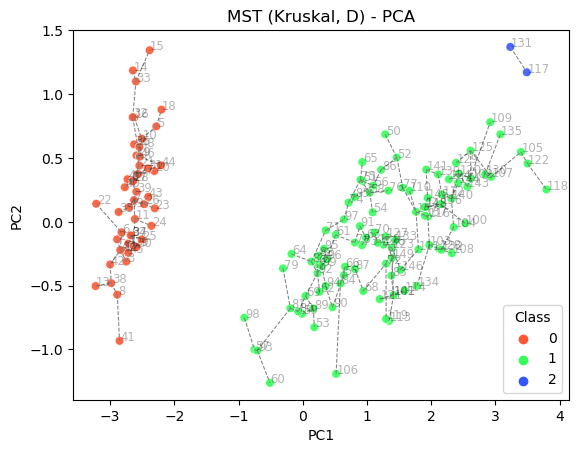

In [27]:
G.kruskal_alg()
cut_mst = G.cut_k_edges_from_mst(N_CLUSTERS-1, G.kruskal_mst)
A = G.get_adjacency_matrix(cut_mst)
comp, classes = G.get_connected_components(A)

data['Class'] = classes
plot_mst(data, cut_mst, 'PC1', 'PC2', 'Class', 'index', 'MST (Kruskal, D) - PCA', 'PC1', 'PC2')

#### Prim's Algorithm without PCA

<AxesSubplot:title={'center':'MST (Prim, D) - PCA'}, xlabel='PC1', ylabel='PC2'>

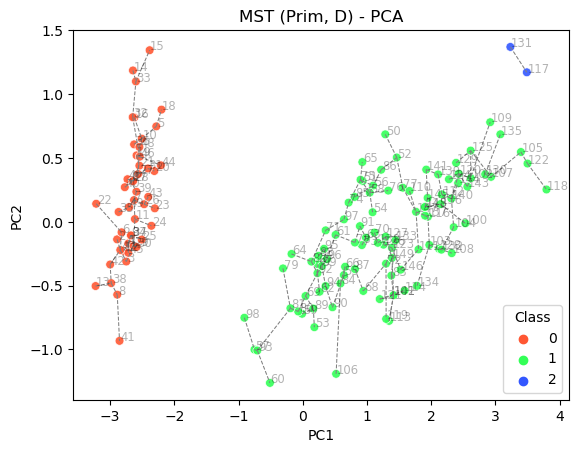

In [28]:
G.prim_alg()
cut_mst = G.cut_k_edges_from_mst(N_CLUSTERS-1, G.prim_mst)
A = G.get_adjacency_matrix(cut_mst)
comp, classes = G.get_connected_components(A)

data['Class'] = classes
plot_mst(data, cut_mst, 'PC1', 'PC2', 'Class', 'index', 'MST (Prim, D) - PCA', 'PC1', 'PC2')

#### Kruskal's Algorithm with previous PCA

<AxesSubplot:title={'center':'MST (Kruskal, D_PCA) - PCA'}, xlabel='PC1', ylabel='PC2'>

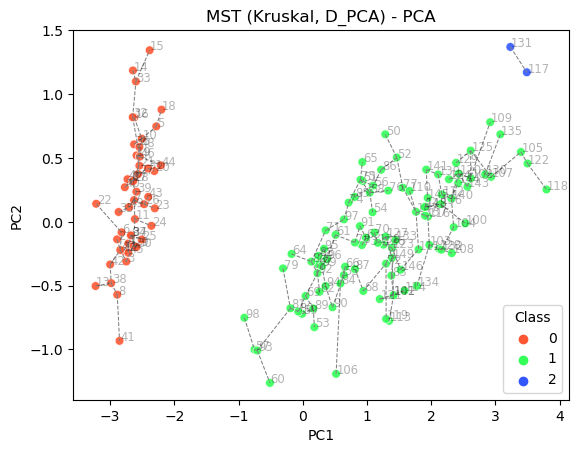

In [29]:
G_PCA.kruskal_alg()
cut_mst = G.cut_k_edges_from_mst(N_CLUSTERS-1, G_PCA.kruskal_mst)
A = G_PCA.get_adjacency_matrix(cut_mst)
comp, classes = G_PCA.get_connected_components(A)

data['Class'] = classes
plot_mst(data, cut_mst, 'PC1', 'PC2', 'Class', 'index', 'MST (Kruskal, D_PCA) - PCA', 'PC1', 'PC2')

#### Prim's Algorithm with previous PCA

<AxesSubplot:title={'center':'MST (Prim, D_PCA) - PCA'}, xlabel='PC1', ylabel='PC2'>

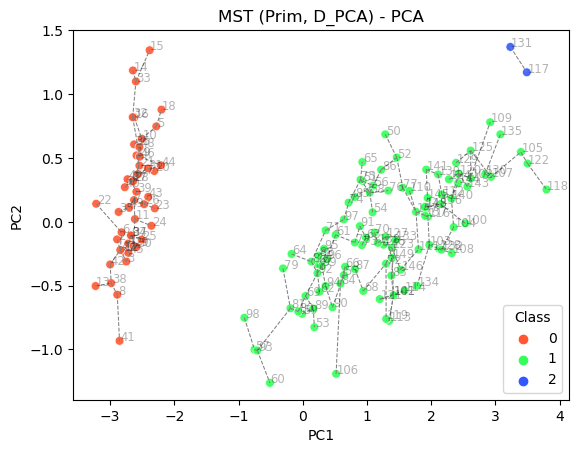

In [30]:
G.prim_alg()
cut_mst = G.cut_k_edges_from_mst(N_CLUSTERS-1, G.prim_mst)
A = G.get_adjacency_matrix(cut_mst)
comp, classes = G.get_connected_components(A)

data['Class'] = classes
plot_mst(data, cut_mst, 'PC1', 'PC2', 'Class', 'index', 'MST (Prim, D_PCA) - PCA', 'PC1', 'PC2')

In [31]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import pairwise_distances
# from sklearn.decomposition import PCA
# from pathlib import Path

# # Constants
# DATA_PATH = Path('wine-clustering.csv')
# DISTANCE_METRIC = 'euclidean'
# REMOVE_OUTLIERS = True
# KEEP_UNDER_PERCENTILE = 75
# N_CLUSTERS = 3

# # Load data
# df = pd.read_csv(DATA_PATH)
# X = df.select_dtypes(include=np.number).to_numpy()

# # Compute distance matrix
# D = pairwise_distances(X, metric=DISTANCE_METRIC)

# # Remove outliers if needed
# if REMOVE_OUTLIERS:
#     points_mean_distance = []
#     means = []
#     for i, point in enumerate(D):
#         points_mean_distance.append((i, np.mean(D[i])))
#         means.append(np.mean(D[i]))

#     threshold = np.percentile(means, KEEP_UNDER_PERCENTILE)
#     points = []
#     for i, distance in points_mean_distance:
#         if distance > threshold:
#             points.append(i)

#     X = np.delete(X, points, axis=0)

# # PCA transformation
# pca = PCA(2)
# X_PCA = pca.fit_transform(X)
# D_PCA = pairwise_distances(X_PCA, metric=DISTANCE_METRIC)

# # Prepare PCA DataFrame
# df_pca = pd.DataFrame(X_PCA, columns=['PC1', 'PC2'])
# data = df_pca.reset_index()

# # Initialize graph structures
# G = Graph()
# G.build_from_distance_matrix(D)

# G_PCA = Graph()
# G_PCA.build_from_distance_matrix(D_PCA)

# # Function to add labels from connected components
# def assign_labels(data, A, G):
#     _, labels = G.get_connected_components(A)
#     data['Label'] = labels
#     return data

# # Function to plot MST with no target
# def plot_mst_with_target(data, mst, x, y, hue, text_column=None, title='MST', xlabel='PC1', ylabel='PC2'):
#     """
#     Plot data points with MST overlaid, using target labels for color coding.
    
#     Args:
#         data (pd.DataFrame): DataFrame containing the data points.
#         mst (list): List of Edge objects representing the MST.
#         x (str): Column name for the x-axis.
#         y (str): Column name for the y-axis.
#         hue (str): Column name for the target labels (color coding).
#         text_column (str, optional): Column name for text labels near each point.
#         title (str): Title of the plot.
#         xlabel (str): Label for the x-axis.
#         ylabel (str): Label for the y-axis.
    
#     Returns:
#         sns.FacetGrid: The scatter plot with MST overlay.
#     """
#     data = data.copy()

#     # Create the scatter plot
#     sns.scatterplot(data=data, x=x, y=y, hue=hue, s=50, palette="deep", legend=True)

#     # Add text beside each point, if provided
#     if text_column:
#         for line in range(data.shape[0]):
#             plt.text(data[x][line] + 0.01, data[y][line], 
#                      data[text_column][line], horizontalalignment='left', 
#                      size='small', color='black')

#     # Add edges from the MST
#     for edge in mst:
#         u, v, w = edge()
#         xuv = [data.iloc[u.id][x], data.iloc[v.id][x]]
#         yuv = [data.iloc[u.id][y], data.iloc[v.id][y]]
#         plt.plot(xuv, yuv, color='grey', linestyle='--', linewidth=0.8)

#     # Set title and axis labels
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend(title=hue)
#     plt.show()

# # Example Usage
# # Assuming `data` has a 'Label' column added from `get_connected_components`
# data['Target'] = classes  # Add labels from connected components to the DataFrame

# # Kruskal (D) - With target
# plot_mst_with_target(data, cut_mst, 'PC1', 'PC2', 'Target', 'index', 'MST (Kruskal, D) - PCA')

# # Prim (D) - With target
# G.prim_alg()
# cut_mst = G.cut_k_edges_from_mst(N_CLUSTERS - 1, G.prim_mst)
# A = G.get_adjacency_matrix(cut_mst)
# comp, classes = G.get_connected_components(A)
# data['Target'] = classes  # Update labels for this MST
# plot_mst_with_target(data, cut_mst, 'PC1', 'PC2', 'Target', 'index', 'MST (Prim, D) - PCA')

# # Kruskal (D_PCA) - With target
# G_PCA.kruskal_alg()
# cut_mst = G_PCA.cut_k_edges_from_mst(N_CLUSTERS - 1, G_PCA.kruskal_mst)
# A = G_PCA.get_adjacency_matrix(cut_mst)
# comp, classes = G_PCA.get_connected_components(A)
# data['Target'] = classes  # Update labels for this MST
# plot_mst_with_target(data, cut_mst, 'PC1', 'PC2', 'Target', 'index', 'MST (Kruskal, D_PCA) - PCA')

# # Prim (D_PCA) - With target
# G_PCA.prim_alg()
# cut_mst = G_PCA.cut_k_edges_from_mst(N_CLUSTERS - 1, G_PCA.prim_mst)
# A = G_PCA.get_adjacency_matrix(cut_mst)
# comp, classes = G_PCA.get_connected_components(A)
# data['Target'] = classes  # Update labels for this MST
# plot_mst_with_target(data, cut_mst, 'PC1', 'PC2', 'Target', 'index', 'MST (Prim, D_PCA) - PCA')